<a href="https://colab.research.google.com/github/drm1072/Data_Sets/blob/main/Deep_Learning_Stock_Prediction_Project_DRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project we will demonstrate how to create a Stock Prediction Model and deploy it for Real World Application.

##          Stock price forecasting model (For 7 days)
We are going to make a machine learning model that can predict stock prices for 7 days. As we are getting our data through an API and by analyzing those data (Historical data) we are going to predict the next 7 days stock price, we can categorize this machine learning model as a supervised machine learning model. This particular problem can also be defined as time series data prediction model as the data is changing chronologically. The data we are getting from the API is labelled data. The labels are 
1.	Open
2.	High
3.	Low
4.	Close
5.	Volume

We are going to predict the Closing price. 
There are many popular algorithms established in the market that can predict stock prices like MLP (Multilayer perceptions), RNN (Recursive neural networks), LSTM (Long short-term memory), CNN (Convolutional neural networks). For this project we are going to use CNN algorithm-based model.

CNN algorithm is a deep learning algorithm that was originally developed to process image data but recently it shows amazing results in predicting sequential data analysis (time series data analysis), which is exactly the type of data we are working with in this project.

We can describe our procedure in some steps:
-	Getting the data through API (we are using alphavantage API): We are using the data of Microsoft company’s stock price.
-	Preprocessing the data
-	EDA (exploratory data analysis): In this case we can divide our EDA process in two parts (1) Cleaning the data (2) Visualizing the data
-	Creating features
-	Setting up the model (CNN model): (1) First we have to construct the model layers (2) Fit the model with the data taken through the API and processed with.
-	Predicting the stock price
-	Visualizing our prediction
-	Deployment of our model



### First, we import the essential data science libraries we will use throughout this project.

In [ ]:
# Importing the essential libraries for our CNN model
import numpy as np #It does fast computations with arrays. As NumPy uses the c programming language in the backend it computes faster. 
import pandas as pd #To work with our dataframe. To manipulate them and save data into optimized dataframes
import matplotlib.pyplot as plt #create custom visualizations/plots of the data
import seaborn as sns; sns.set() #sets the style of plots

### Getting the Data

In [ ]:
#This code pulls the data from the alphavantage API 
#Right now it is just microsoft's data
import requests
API_KEY = 'FYEEXVSKRKYAO1VI'
ticker="MSFT"
r = requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+ticker+"&apikey="+API_KEY)
if (r.status_code == 200):
  print(r.json())

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'MSFT', '3. Last Refreshed': '2021-07-16', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2021-07-16': {'1. open': '282.0700', '2. high': '284.1000', '3. low': '279.4600', '4. close': '280.7500', '5. volume': '26186848'}, '2021-07-15': {'1. open': '282.0000', '2. high': '282.5100', '3. low': '279.8300', '4. close': '281.0300', '5. volume': '22604227'}, '2021-07-14': {'1. open': '282.3450', '2. high': '283.6600', '3. low': '280.5500', '4. close': '282.5100', '5. volume': '23113662'}, '2021-07-13': {'1. open': '277.5200', '2. high': '282.8477', '3. low': '277.3900', '4. close': '280.9800', '5. volume': '26120128'}, '2021-07-12': {'1. open': '279.1570', '2. high': '279.7700', '3. low': '276.5800', '4. close': '277.3200', '5. volume': '18931695'}, '2021-07-09': {'1. open': '275.7200', '2. high': '278.0500', '3. low': '275.3200', '4. close': '277.9400', '5

Helper function for cleaning the data

In [ ]:
def clean_data(data):
    #Raw data from API 
    df = pd.DataFrame.from_dict(data, orient="index")
    #Transposing Data and Taking column with data
    df2 = (df.T['Time Series (Daily)'])
    #Dropping all NAs
    df2 = df2.dropna()
    df_convert = df2.to_frame()
    #We will take the data from this and use it to index our dataframe 
    df_index = list(df_convert.index)
    #Convert to cleaned dataframe 
    df2 = pd.json_normalize(df2)
    #We add this list to the dataframe with our actual data
    df2['Index'] = df_index
    #We then set the index column as our actual index
    df2 = df2.set_index('Index')
    #Put the data in the correct order
    df2 = df2[::-1]
    return df2

In [ ]:
df=clean_data(r.json())

In [ ]:
df

,1. open,2. high,3. low,4. close,5. volume
Index,,,,,
2021-02-24,230.0100,235.2000,229.0000,234.5500,26339746
2021-02-25,232.0800,234.5852,227.8800,228.9900,39118089
2021-02-26,231.5250,235.3700,229.5400,232.3800,37545055
2021-03-01,235.9000,237.4700,233.1500,236.9400,25332837
2021-03-02,237.0100,237.3000,233.4500,233.8700,22812459
...,...,...,...,...,...
2021-07-12,279.1570,279.7700,276.5800,277.3200,18931695
2021-07-13,277.5200,282.8477,277.3900,280.9800,26120128
2021-07-14,282.3450,283.6600,280.5500,282.5100,23113662


In [ ]:
#pd.options.display.max_rows=100 #This is the code to display max rows

In [ ]:
#df #since there is only 100 rows I want to manually check to see if there are any irregularities or potential nan values

### Processing the Data and Generating Features

Checking the column data types

In [ ]:
df.dtypes #check data types of each column

1. open      object
2. high      object
3. low       object
4. close     object
5. volume    object
dtype: object

We need to convert the index to a datetime object and the other columns to numbers:

In [ ]:
def conv_types(data):
    data.index=pd.to_datetime(data.index) #convert the index to a datetime object for plotting
    #convert each column to integers for plotting and model input
    data['1. open']=pd.to_numeric(data['1. open'])
    data['2. high']=pd.to_numeric(data['2. high'])
    data['3. low']=pd.to_numeric(data['3. low'])
    data['4. close']=pd.to_numeric(data['4. close'])
    data['5. volume']=pd.to_numeric(data['5. volume'])
    return df

In [ ]:
df=conv_types(df)

In [ ]:
df.dtypes #verify type conversions

1. open      float64
2. high      float64
3. low       float64
4. close     float64
5. volume      int64
dtype: object

In [ ]:
def plot_data(data):
    plt.figure(figsize=(22,6)) #set the size of the figure
    plt.subplot(1,2,1)
    #create two subplots - one for daily prices, one for daily volume
    plt.plot(data['1. open'], color='blue', label="Open")
    plt.plot(data['2. high'], color='green', label="High")
    plt.plot(data['3. low'], color='red', label="Low")
    plt.plot(data['4. close'], color='purple', label="Close")
    plt.title(str("Microsoft ($MSFT) Daily Stock Price\n"+str(data.index[0].date())+" to "+str(data.index[-1].date())))
    plt.xlabel("Date")
    plt.ylabel("Price in USD")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(data['5. volume'], color='orange', label="Volume")
    plt.title(str("Microsoft ($MSFT) Daily Trading Volume\n"+str(data.index[0].date())+" to "+str(data.index[-1].date())))
    plt.xlabel("Date")
    plt.ylabel("Trading Volume in millions")
    plt.show()

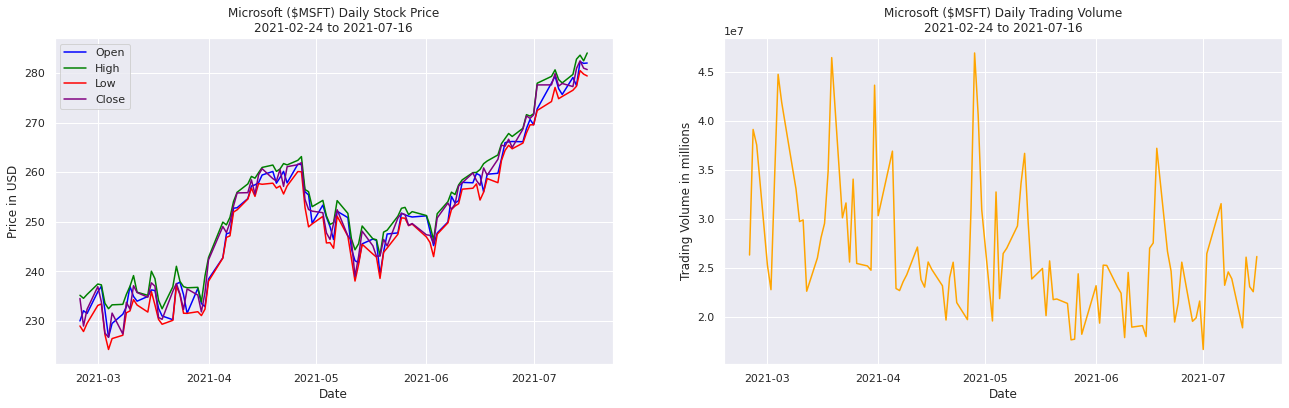

In [ ]:
plot_data(df)

## Setting up the Model

### Preprocessing

In [ ]:
#helper function to split the time series (explained in next block of code)
def split_sequence(sequence, n_steps):
	X, y = list(), list() #create empty lists to store X and y variables
	for i in range(len(sequence)):

		# find the end of this pattern
		end_ix = i + n_steps

		# check if we are beyond the sequence
		#if we are, simply stop executing this block of code
		if end_ix > len(sequence)-1:
			break

		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 	

In [ ]:
seq_length = 5 #seq_length tells how many sequential data points are used for each element of the array
#5 means 5 data points will be used at a time
#for instance, the first element of the array will be data points 1-5
#the second element of the array will be data points 2-6
#third element will be data points 3-7, and so on

#we only need the close price data for our model
data = np.array(df['4. close'])

#splitting the data with our helper function
X, y = split_sequence(data, seq_length)

In [ ]:
#reshape from [samples, timesteps] into [samples, timesteps, features] for training the model
#the model requires these three values for input
n_features = 1 #our only feature, or input variable, is the closing stock price
X = X.reshape((X.shape[0], X.shape[1], n_features))

### Constructing the model layers

In [ ]:
import tensorflow as tf #backend for keras
from tensorflow import keras #used for creating the CNN model
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D #the data is 1-dimensional so we will use a 1d convolution layer

In [ ]:
#define/setup model
model = Sequential()

#add a 1d convolutional layer
#64 filters used in the convolution operation (a somewhat arbitrary choice)
#kernel_size of 2 means the convolutional layer reads 2 data points at a time, applies the filters, and outputs it to the next layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, n_features)))

#add a pooling layer, which reduces the dimensionality of the input size
#takes the max value of each window of length 2
model.add(MaxPooling1D(pool_size=2))

#flattens the data into a 1d vector - first layer of the fully connected layers
model.add(Flatten())

#dense layer with relu activation
#outputs zero for values less than or equal to zero and keeps positive values the same
model.add(Dense(50, activation='relu'))

#1d dense layer to generate the predicted value
#only 1 dimensional because only one value is being predicted at each time point
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

### Fitting the model

In [ ]:
#the model is fitted on the training data over 100 epochs to improve and update its parameters
#verbose controls how detailed the output is when training the model
def fit_model(X, y):
    """Trains the neural network"""
    model.fit(X, y, epochs=100, verbose=2)

In [ ]:
fit_model(X,y)

Epoch 1/100
3/3 - 15s - loss: 77841.0469
Epoch 2/100
3/3 - 0s - loss: 62135.0508
Epoch 3/100
3/3 - 0s - loss: 48595.7930
Epoch 4/100
3/3 - 0s - loss: 36521.1562
Epoch 5/100
3/3 - 0s - loss: 26234.8008
Epoch 6/100
3/3 - 0s - loss: 18195.8945
Epoch 7/100
3/3 - 0s - loss: 12069.8496
Epoch 8/100
3/3 - 0s - loss: 7369.9370
Epoch 9/100
3/3 - 0s - loss: 3898.9480
Epoch 10/100
3/3 - 0s - loss: 1626.2452
Epoch 11/100
3/3 - 0s - loss: 437.5434
Epoch 12/100
3/3 - 0s - loss: 51.4718
Epoch 13/100
3/3 - 0s - loss: 108.0953
Epoch 14/100
3/3 - 0s - loss: 340.7934
Epoch 15/100
3/3 - 0s - loss: 536.1133
Epoch 16/100
3/3 - 0s - loss: 589.5861
Epoch 17/100
3/3 - 0s - loss: 508.4874
Epoch 18/100
3/3 - 0s - loss: 354.4681
Epoch 19/100
3/3 - 0s - loss: 201.2137
Epoch 20/100
3/3 - 0s - loss: 90.3847
Epoch 21/100
3/3 - 0s - loss: 31.1056
Epoch 22/100
3/3 - 0s - loss: 18.2039
Epoch 23/100
3/3 - 0s - loss: 26.3701
Epoch 24/100
3/3 - 0s - loss: 39.8695
Epoch 25/100
3/3 - 0s - loss: 47.6591
Epoch 26/100
3/3 - 0s -

## Creating the predictions

In [ ]:
DAYS_TO_PREDICT = 7
def make_predictions(X, DAYS_TO_PREDICT):
    test_seq = X[-1:] #set the test sequence to start at the most recent stock values
    preds = [] #create empty list to store predictions

    #create predictions using most recent 5 data points
    #the first prediction will assist in making the second prediction, and so on
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq) #outputs the prediction from our test sequence
        pred = y_test_pred #assign pred to the raw output of the model for rebuilding new_seq and test_seq
        preds.append(y_test_pred) #add the prediction to the list we will use for plotting
        new_seq = test_seq.flatten() #flatten the output from the model into a 1d array
        new_seq = np.append(new_seq, [pred]) #add prediction to the list the model is using to make predictions
        new_seq = new_seq[1:] #exclude the first element from the list; use our most recent prediction for the next prediction instead
        test_seq = new_seq.reshape(1, seq_length, 1) #reshape for the model
    preds=np.array(preds).reshape(DAYS_TO_PREDICT,) #reshape the prediction array for plotting
    return preds

In [ ]:
predicted_price=make_predictions(X, 7)

In [ ]:
def make_pred_index(data, preds):
    """creating the datetime index for our predictions to be just after our actual data"""
    predicted_index = pd.date_range(start=data.index[-1], #start 1 day beyond existing data
                                    periods=DAYS_TO_PREDICT+1, #run time interval through days predicted
                                    closed='right') #include the last value of the time frame
    return predicted_index

def make_pred_series(preds, predicted_index):
    """create new series of predicted prices with corresponding dates predicted"""
    predicted_price = pd.Series(data=preds,
                                index=predicted_index)
    return predicted_price

In [ ]:
predicted_index = make_pred_index(df, predicted_price)
predicted_price = make_pred_series(predicted_price, predicted_index)

### Visualizing the predictions

In [ ]:
def plot_predictions(data, predictions):
    """Takes the dataframe of historical data and Series of predictions as input"""
    plt.figure(figsize=(15,6))
    plt.plot(data['4. close'][:-1], #plot data used for training the model
         label='Historical Daily Price')
    
    plt.plot(predictions, '.-', #plot predictions
             label='Predicted Daily Price')
    plt.title("MSFT daily closing price (2020)\nPrediction for "+str(predictions.index[0].date())+" to "+str(predictions.index[-1].date()))
    plt.legend()
    plt.show()

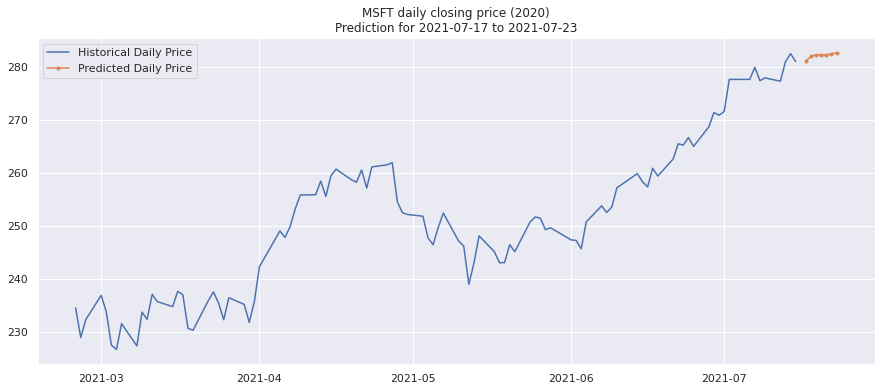

In [ ]:
plot_predictions(df, predicted_price)

In [ ]:
def plot_predictions_recent(data, predictions):
    plt.figure(figsize=(15,6))
    #plot data used for training the model
    plt.plot(data[data.index>="2020-08-01"]['4. close'][:-1],
            label='Historical Daily Price')

    #add the predcited prices to the plot
    plt.plot(predictions, '.-',
            label='Predicted Daily Price')
    plt.title("MSFT daily closing price (2020)\nPrediction for "+str(predictions.index[0].date())+" to "+str(predictions.index[-1].date()))
    plt.legend()
    plt.show()

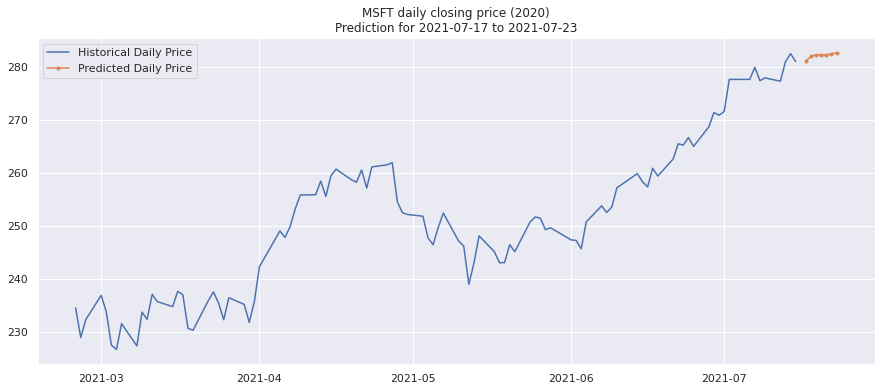

In [ ]:
plot_predictions_recent(df, predicted_price)

Interpretation:

In blue we see the historical price stock price and in orange we see the prediction for 7 days into the future.  As one can see since the shut down becuase of COVID, Microsoft stock has risen steadily over time.  This is expected as many big tech stocks have seen an increase in stock price because in this virtual world because there is an even greater reliance on their products. 

Microsoft dropped from a little above 230 to just above 200 during the first week of September.  Our model predicts a slight increase within the next week to at about 207. 

### Backtesting

We had to do break up our data for backtesting in an untraditional way.  This is because the way the stocks behave, they are to eradict to predict from just an 80 20 test split. What we ended up doing is removing the last week's worth of data, running that dataframe through the model then comparing the predicted to the actual.

In [ ]:
df_backtest = df[:-5] # remove the last 5 data points to keep the most recent full week

In [ ]:
df_backtest

,1. open,2. high,3. low,4. close,5. volume
Index,,,,,
2021-02-24,230.010,235.2000,229.00,234.55,26339746
2021-02-25,232.080,234.5852,227.88,228.99,39118089
2021-02-26,231.525,235.3700,229.54,232.38,37545055
2021-03-01,235.900,237.4700,233.15,236.94,25332837
2021-03-02,237.010,237.3000,233.45,233.87,22812459
...,...,...,...,...,...
2021-07-02,272.820,278.0000,272.50,277.65,26474408
2021-07-06,278.030,279.3698,274.30,277.66,31565560
2021-07-07,279.400,280.6945,277.15,279.93,23260031


In [ ]:
#we only need the close price data for our model
data_bt = np.array(df_backtest['4. close'])

#splitting the data with our helper function
X_bt, y_bt = split_sequence(data_bt, seq_length)

In [ ]:
#reshape from [samples, timesteps] into [samples, timesteps, features] for training the model
#the model requires these three values for input
n_features = 1 #our only feature, or input variable, is the closing stock price
X_bt = X_bt.reshape((X_bt.shape[0], X_bt.shape[1], n_features))

In [ ]:
#define/setup model
model_bt = Sequential()

#add a 1d convolutional layer
#64 filters used in the convolution operation (a somewhat arbitrary choice)
#kernel_size of 2 means the convolutional layer reads 2 data points at a time, applies the filters, and outputs it to the next layer
model_bt.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, n_features)))

#add a pooling layer, which reduces the dimensionality of the input size
#takes the max value of each window of length 2
model_bt.add(MaxPooling1D(pool_size=2))

#flattens the data into a 1d vector - first layer of the fully connected layers
model_bt.add(Flatten())

#dense layer with relu activation
#outputs zero for values less than or equal to zero and keeps positive values the same
model_bt.add(Dense(50, activation='relu'))

#1d dense layer to generate the predicted value
#only 1 dimensional because only one value is being predicted at each time point
model_bt.add(Dense(1))

model_bt.compile(optimizer='adam', loss='mse')

In [ ]:
model_bt.fit(X_bt, y_bt, epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 5ms/step - loss: 72177.8320
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 53463.5645
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 38737.7646
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 27613.8408
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 18267.1851
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 11045.4790
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 5721.0660
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 2224.6915
Epoch 9/100
3/3 [==============================] - 0s 7ms/step - loss: 426.1421
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 50.0976
Epoch 11/100
3/3 [==============================] - 0s 5ms/step - loss: 403.9442
Epoch 12/100
3/3 [==============================] - 0s 5ms/step - loss: 917.0741
Epoch 13/100
3/3 [======

In [ ]:
DAYS_TO_PREDICT = 7
def make_predictions_bt(X, DAYS_TO_PREDICT):
    test_seq = X[-1:] #set the test sequence to start at the most recent stock values
    preds = [] #create empty list to store predictions
    #create predictions using most recent 5 data points
    #the first prediction will assist in making the second prediction, and so on
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model_bt(test_seq) #outputs the prediction from our test sequence
        pred = y_test_pred #assign pred to the raw output of the model for rebuilding new_seq and test_seq
        preds.append(y_test_pred) #add the prediction to the list we will use for plotting
        new_seq = test_seq.flatten() #flatten the output from the model into a 1d array
        new_seq = np.append(new_seq, [pred]) #add prediction to the list the model is using to make predictions
        new_seq = new_seq[1:] #exclude the first element from the list; use our most recent prediction for the next prediction instead
        test_seq = new_seq.reshape(1, seq_length, 1) #reshape for the model
    preds=np.array(preds).reshape(DAYS_TO_PREDICT,) #reshape the prediction array for plotting
    return preds

In [ ]:
predicted_price_bt = make_predictions_bt(X_bt, 7)

In [ ]:
predicted_index_bt = make_pred_index(df_backtest, predicted_price_bt)
predicted_price_bt = make_pred_series(predicted_price_bt, predicted_index_bt)

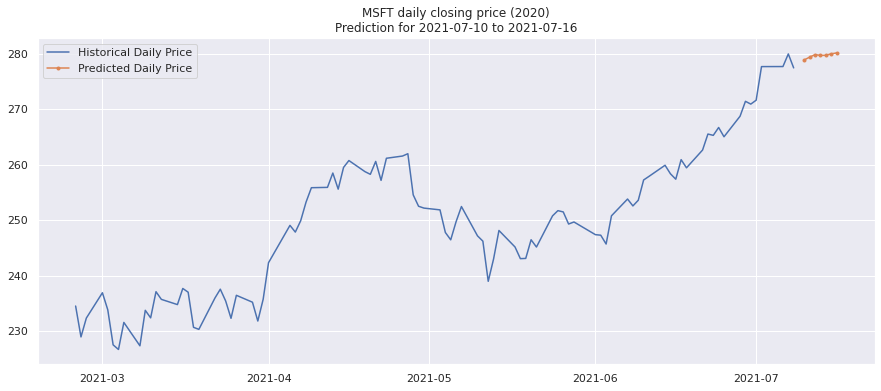

In [ ]:
plot_predictions(df_backtest, predicted_price_bt)

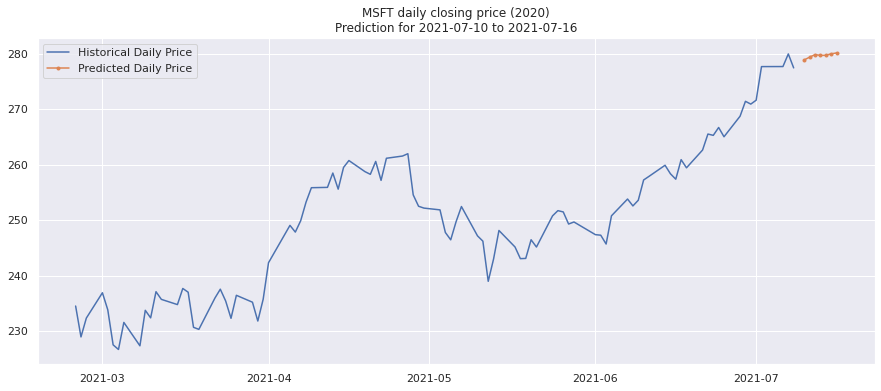

In [ ]:
plot_predictions_recent(df_backtest, predicted_price_bt)

#### Comparing our predicion to the true values

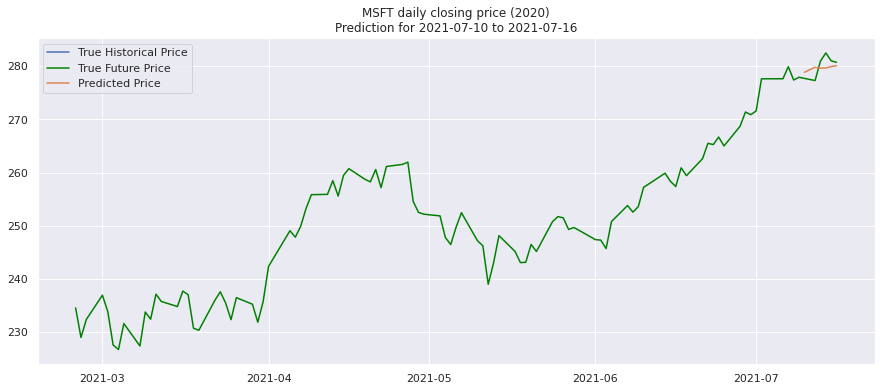

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df[(df.index<="2020-09-11") & (df.index>="2020-07-01")]['4. close'], label='True Historical Price')
plt.plot(df[df.index>="2020-09-14"]['4. close'], label='True Future Price', color='green')
plt.plot(predicted_price_bt, label='Predicted Price')
plt.title("MSFT daily closing price (2020)\nPrediction for "+str(predicted_price_bt.index[0].date())+" to "+str(predicted_price_bt.index[-1].date()))
plt.legend()
plt.show()

In [ ]:
print(tf.__version__)

2.5.0


### Deploy

In [ ]:
# Importing the essential libraries
!pip install flask_ngrok
!pip install pyngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
import os
import numpy as np #fast computations with arrays
import pandas as pd #save data into optimized dataframes
import matplotlib.pyplot as plt #create custom visualizations/plots of the data
import seaborn as sns; sns.set() #sets the style of plots

--2021-07-18 21:21:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.45.37.112, 34.228.108.156, 3.216.86.20, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.45.37.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.19M  17.8MB/s    in 0.7s    

2021-07-18 21:21:39 (17.8 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13832437/13832437]



In [ ]:
#This code pulls the data from the alpavantage api 
#Right now it is just microsoft's data
import requests

#helper function to split the time series (explained in next block of code)
def split_sequence(sequence, n_steps):
	X, y = list(), list() #create empty lists to store X and y variables
	for i in range(len(sequence)):

		# find the end of this pattern
		end_ix = i + n_steps

		# check if we are beyond the sequence
		#if we are, simply stop executing this block of code
		if end_ix > len(sequence)-1:
			break

		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
  
	return np.array(X), np.array(y)
 
def our_model(ticker, DAYS_TO_PREDICT):
  API_KEY = 'FYEEXVSKRKYAO1VI'
  r = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+ticker+'&apikey='+API_KEY)
  #Raw data from API 
  df = pd.DataFrame.from_dict(r.json(), orient="index")
  #Transposing Data and Taking column with data
  df2 = (df.T['Time Series (Daily)'])
  #Dropping all NAs
  df2 = df2.dropna()
  df_convert = df2.to_frame()
  #We will take the data from this and use it to index our dataframe 
  df_index = list(df_convert.index)
  #Convert to cleaned dataframe 
  df2 = pd.json_normalize(df2)
  #We add this list to the dataframe with our actual data
  df2['Index'] = df_index
  #We then set the index column as our actual index
  df2 = df2.set_index('Index')
  #Put the data in the correct order
  df2 = df2[::-1] #reverse the order of the dataframe
  df2.index=pd.to_datetime(df2.index) #convert the index to a datetime object for plotting
  #convert each column to integers for plotting and model input
  df2['1. open']=pd.to_numeric(df2['1. open'])
  df2['2. high']=pd.to_numeric(df2['2. high'])
  df2['3. low']=pd.to_numeric(df2['3. low'])
  df2['4. close']=pd.to_numeric(df2['4. close'])
  df2['5. volume']=pd.to_numeric(df2['5. volume'])

  seq_length = 5 #seq_length tells how many sequential data points are used for each element of the array
  #5 means 5 data points will be used at a time
  #for instance, the first element of the array will be data points 1-5
  #the second element of the array will be data points 2-6
  #third element will be data points 3-7, and so on

  #we only need the close price data for our model
  data = np.array(df2['4. close'])

  #splitting the data with our helper function
  X, y = split_sequence(data, seq_length)

  #reshape from [samples, timesteps] into [samples, timesteps, features] for training the model
  #the model requires these three values for input
  n_features = 1 #our only feature, or input variable, is the closing stock price
  X = X.reshape((X.shape[0], X.shape[1], n_features))

  import tensorflow as tf #backend for keras
  from tensorflow import keras #used for creating the CNN model
  from keras.models import Sequential
  from keras.layers import Flatten, Dense
  from keras.layers.convolutional import Conv1D, MaxPooling1D #the data is 1-dimensional so we will use a 1d convolution layer

  #define/setup model
  model = Sequential()

  #add a 1d convolutional layer
  #64 filters used in the convolution operation (a somewhat arbitrary choice)
  #kernel_size of 2 means the convolutional layer reads 2 data points at a time, applies the filters, and outputs it to the next layer
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, n_features)))

  #add a pooling layer, which reduces the dimensionality of the input size
  #takes the max value of each window of length 2
  model.add(MaxPooling1D(pool_size=2))

  #flattens the data into a 1d vector - first layer of the fully connected layers
  model.add(Flatten())

  #dense layer with relu activation
  #outputs zero for values less than or equal to zero and keeps positive values the same
  model.add(Dense(50, activation='relu'))

  #1d dense layer to generate the predicted value
  #only 1 dimensional because only one value is being predicted at each time point
  model.add(Dense(1))

  model.compile(optimizer='adam', loss='mse')

  #the model is fitted on the training data over 100 epochs to improve and update its parameters
  #verbose controls how detailed the output is when training the model
  model.fit(X, y, epochs=100)

  test_seq = X[-1:] #set the test sequence to start at the most recent stock values
  preds = [] #create empty list to store predictions
  #DAYS_TO_PREDICT=7 #number of future days to predict

  #create predictions using most recent 5 data points
  #the first prediction will assist in making the second prediction, and so on
  for _ in range(DAYS_TO_PREDICT):
      y_test_pred = model(test_seq) #outputs the prediction from our test sequence
      pred = y_test_pred #assign pred to the raw output of the model for rebuilding new_seq and test_seq
      preds.append(y_test_pred) #add the prediction to the list we will use for plotting
      new_seq = test_seq.flatten() #flatten the output from the model into a 1d array
      new_seq = np.append(new_seq, [pred]) #add prediction to the list the model is using to make predictions
      new_seq = new_seq[1:] #exclude the first element from the list; use our most recent prediction for the next prediction instead
      test_seq = new_seq.reshape(1, seq_length, 1) #reshape for the model
  preds=np.array(preds).reshape(DAYS_TO_PREDICT,) #reshape the prediction array for plotting

  #creating the datetime index for our predictions to be just after our actual data
  predicted_index = pd.date_range(
    start=df2.index[-2], #start 1 day beyond existing data
    periods=DAYS_TO_PREDICT+1, #run time interval through days ahead predicted
    closed='right') #include the last value of the time frame

  #create new series with predicted prices for corresponding dates predicted
  predicted_price = pd.Series(
    data=preds,
    index=predicted_index)
  
#   plt.figure(figsize=(15,6))
#   plt.plot(df2['4. close'][:-1], #plot data used for training the model
#          label='Historical Daily Price')
#   plt.plot(predicted_price, #plot predictions
#          label='Predicted Daily Price')
#   plt.title(label=ticker+" daily closing price")
#   plt.legend()
#   plt.savefig("pred_prices.png")
  
  return predicted_price
  

  #plt.figure(figsize=(15,6))
  #plot data used for training the model
  #plt.plot(df2[df2.index>="2020-08-01"]['4. close'][:-1],
         #label='Historical Daily Price')

  #add the predcited prices to the plot
  #plt.plot(predicted_price,
          #label='Predicted Daily Price')
  #plt.title(ticker + " daily closing price (2020)\nPredction for "+str(predicted_price.index[0].date())+" to "+str(predicted_price.index[-1].date()))
  #plt.legend()
  #return plt.show()


In [ ]:
#source: https://medium.com/@kshitijvijay271199/flask-on-google-colab-f6525986797b
#other source: https://www.youtube.com/watch?v=Pc8WdnIdXZg
from flask import Flask, request #importing Flask to run the model on a host
from flask_ngrok import run_with_ngrok #importing ngrok to make Flask apps available on the internet (in this case, temporarily)
from pyngrok import ngrok
app = Flask(__name__)
#!ngrok authtoken 1hsQiSSJ05rnXkZfXKgyLkgMMbn_6Bfshx2Do22MRtsZYT9aM
#!killall ngrok
#get_ipython().system_raw('./ngrok http 5000 &')
#!ngrok http -subdomain=priceforecasting 5000 

#!ngrok by @priceforecasting
run_with_ngrok(app)   #starts ngrok when the app is run
@app.route("/") #Assigns "/" as the URL for the home function, using Flask
def home():
  #return a simple form with a title and place for ticker and a button named "Predict"
    return '''<form action='/predict' method="post" class="col s12">
      <div class="row">
        <div class="input-field col s4">
            <label for="first_name"><b>Ticker</b></label>
            <br>
          <input placeholder="Ticker" name="Ticker" id="first_name" type="text" class="validate">
        </div> 
        <div class="row center">

          <button type="submit" class="btn-large waves-effect waves-light orange">Predict</button>
        </div>
      </div>
      </form>
        '''
@app.route('/predict',methods=['POST','GET']) #Assigns "/predict" as the URL for the predict function, using Flask
def predict():
  ticker = request.form["Ticker"] #extract the ticker 
  prediction = our_model(ticker, 7) #supply the ticker to the model and get the 7-day prediction from the model
  table = prediction.to_frame() #convert the predicted results in pandas series to pandas dataframe
  table.columns = ["Predicted Close Price"] #add a column named "Predicted Close Price"
  html = table.to_html() #convert the dataframe into the html version
  #next, return the table of dates along with the Predicted Close Prices
  return '''<form action='/predict' method="post" class="col s12">
      <div class="row">
        <div class="input-field col s4">
            <label for="first_name"><b>Ticker</b></label>
            <br>
          <input placeholder="Ticker" name="Ticker" id="first_name" type="text" class="validate">
        </div> 
        <div class="row center">

          <button type="submit" class="btn-large waves-effect waves-light orange">Predict</button>
        </div>
      </div>
      </form>
      </div>

      <br>
        ''' + "<h2> 7-day forecast for " + ticker + "</h2>"+ html + '''<br>

    </div>
        ''' 

app.run() #run the Flask app


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://04a5039f8a95.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [18/Jul/2021 21:22:32] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jul/2021 21:22:32] "GET /favicon.ico HTTP/1.1" 404 -


Epoch 1/100
3/3 [==============================] - 1s 4ms/step - loss: 10913.8750
Epoch 2/100
3/3 [==============================] - 0s 6ms/step - loss: 7663.4968
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 5096.0424
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 3232.8972
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 1834.2645
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 817.8390
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 232.8791
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 17.7411
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 61.4889
Epoch 10/100
3/3 [==============================] - 0s 8ms/step - loss: 183.8376
Epoch 11/100
3/3 [==============================] - 0s 5ms/step - loss: 246.6915
Epoch 12/100
3/3 [==============================] - 0s 4ms/step - loss: 242.8368
Epoch 13/100
3/3 [==============

127.0.0.1 - - [18/Jul/2021 21:22:42] "POST /predict HTTP/1.1" 200 -
